# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import seaborn as sb
% matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio['simple_id'] = portfolio.index+1

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,simple_id
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,3
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,4
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,6
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,7
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,8
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,9
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,10


In [4]:
def email(lst):
    if 'email' in lst:
        return 1
    else:
        return 0
def mobile(lst):
    if 'mobile' in lst:
        return 1
    else:
        return 0
def web(lst):
    if 'web' in lst:
        return 1
    else:
        return 0
def social(lst):
    if 'social' in lst:
        return 1
    else:
        return 0
portfolio['email'] = portfolio['channels'].apply(lambda x: email(x))
portfolio['mobile'] = portfolio['channels'].apply(lambda x: mobile(x))
portfolio['web'] = portfolio['channels'].apply(lambda x: web(x))
portfolio['social'] = portfolio['channels'].apply(lambda x: social(x))
                                    

In [5]:
offer_type = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio, offer_type], axis = 1)

In [6]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,simple_id,email,mobile,web,social,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,2,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,3,1,1,1,0,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,4,1,1,1,0,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,5,1,0,1,0,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,6,1,1,1,1,0,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,7,1,1,1,1,0,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,8,1,1,0,1,0,0,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,9,1,1,1,1,1,0,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,10,1,1,1,0,0,1,0


In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [10]:
profile[profile['income'].isnull()]

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN
11,118,2015-09-19,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,2017-08-01,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,2017-09-07,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [11]:
profile[profile['income'].isnull()]['age'].unique()

array([118])

In [12]:
profile[profile['gender'].isnull()]['age'].unique()

array([118])

> Income and gender are null all have age 118

In [13]:
profile.groupby('age').size()

age
18       70
19      135
20      135
21      140
22      131
23      126
24      139
25      136
26      157
27      139
28      137
29      129
30      131
31      113
32      139
33      152
34      147
35      118
36      175
37      197
38      172
39      182
40      202
41      189
42      227
43      215
44      192
45      231
46      212
47      232
       ... 
73      209
74      193
75      159
76      155
77      141
78      135
79      117
80      116
81      118
82      105
83      102
84       83
85       70
86       54
87       66
88       64
89       53
90       52
91       47
92       40
93       29
94       33
95       22
96        8
97       13
98        5
99        5
100      12
101       5
118    2175
Length: 85, dtype: int64

> Age 118 all have missing value in gender and income

#### Check the distribution of the age

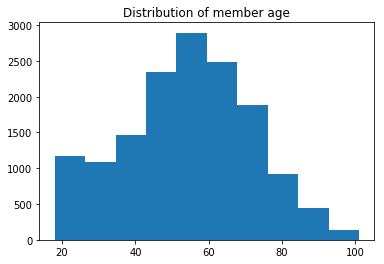

In [14]:
plt.hist(profile.query('age != 118')['age'])
plt.title('Distribution of member age');

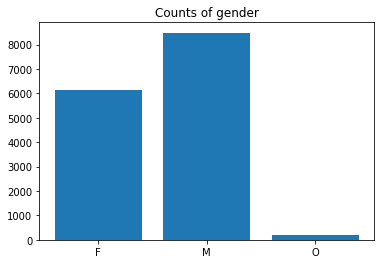

In [15]:
plt.bar(profile.query('age != 118').groupby(['gender']).size().index,profile.query('age != 118').groupby(['gender']).size().values)
plt.title('Counts of gender');

In [16]:
profile.query('age != 118')['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

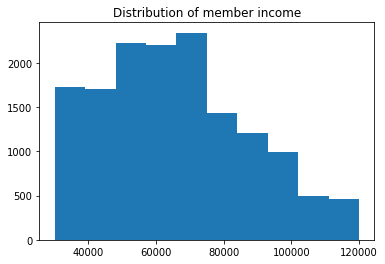

In [17]:
plt.hist(profile.query('age != 118')['income'])
plt.title('Distribution of member income');

In [18]:
print(profile.query('age != 118')['income'].mode())
profile.query('age != 118')['income'].describe()

0    73000.0
dtype: float64


count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [19]:
def gender_na(x):
    if not x:
        data = profile.query('age != 118')['gender']
        gender = np.random.choice(data)
        return gender
    else:
        return x
profile['gender'] = profile['gender'].apply(lambda x: gender_na(x))
profile['income'] = profile['income'].fillna(round(profile['income'].mean()))
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65405.0
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65405.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,F,a03223e636434f42ac4c3df47e8bac43,65405.0


In [20]:
def clean_age_118(x):
    if x == 118:
        return round(profile.query('age !=118')['age'].mean())
    else:
        return x
profile['age'] = profile.age.apply(lambda x: clean_age_118(x))
profile.head()

,age,became_member_on,gender,id,income
0,54.0,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65405.0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,54.0,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65405.0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,54.0,2017-08-04,F,a03223e636434f42ac4c3df47e8bac43,65405.0


In [21]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [22]:
def offer_id(dct):
    for key, value in dct.items():
        if 'offer' in key:
            return str(value)
    else:
        return np.nan
transcript['offer_id'] = transcript['value'].apply(lambda x: offer_id(x))
transcript.head()

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [23]:
transcript = transcript.merge(portfolio[['id','simple_id']], how = 'left', left_on = 'offer_id', right_on = 'id')
transcript.drop(['offer_id', 'id'], axis = 1, inplace = True)
transcript = transcript.rename(columns = {'simple_id': 'offer_id'})

In [24]:
def trans_amt(dct):
    for key, value in dct.items():
        if 'amount' in key:
            return float(value)
    else:
        return np.nan
transcript['trans_amt'] = transcript['value'].apply(lambda x: trans_amt(x))
transcript.head()

,event,person,time,value,offer_id,trans_amt
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},4.0,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5.0,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},10.0,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},7.0,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2.0,NaN


In [25]:
transcript.query('offer_id == "8"')['event'].unique()

array(['offer received', 'offer viewed'], dtype=object)

In [26]:
transcript.groupby(['person','event']).size()

person                            event          
0009655768c64bdeb2e877511632db8f  offer completed     3
                                  offer received      5
                                  offer viewed        4
                                  transaction         8
00116118485d4dfda04fdbaba9a87b5c  offer received      2
                                  offer viewed        2
                                  transaction         3
0011e0d4e6b944f998e987f904e8c1e5  offer completed     3
                                  offer received      5
                                  offer viewed        5
                                  transaction         5
0020c2b971eb4e9188eac86d93036a77  offer completed     3
                                  offer received      5
                                  offer viewed        3
                                  transaction         8
0020ccbbb6d84e358d3414a3ff76cffd  offer completed     3
                                  offer received      

In [27]:
transcript.query('event == "offer completed"').groupby('offer_id').size().sort_values(ascending = False)

offer_id
7.0     5317
6.0     5156
4.0     4354
9.0     4296
10.0    4017
1.0     3688
5.0     3420
2.0     3331
dtype: int64

In [28]:
print(transcript.query('offer_id == 8')['event'].unique())
print(transcript.query('offer_id == 3')['event'].unique())

['offer received' 'offer viewed']
['offer received' 'offer viewed']


> Informational offer only have offer received and offer viewed events. Therefor, if we want to analyze transaction and offer completed we should exclude these two offers.

In [29]:
trans_ppl = transcript.merge(profile, how = 'left', left_on = 'person', right_on = 'id')
trans_ppl.drop('id', axis = 1, inplace = True)

In [30]:
# Exclude informational offer
not_inf = trans_ppl.query('offer_id !=  8 and offer_id !=  3')

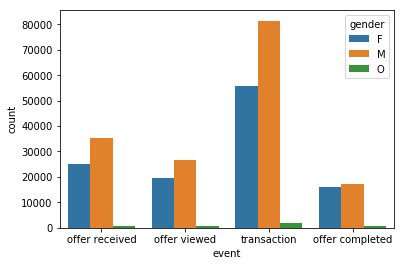

In [31]:
sb.countplot(data = not_inf, x = 'event', hue = 'gender')

> We have more male so I will use the percentage to see the distribution

In [32]:
not_inf.gender.value_counts()

M    160322
F    116148
O      3998
Name: gender, dtype: int64

In [33]:
def genderpct(x):
    return gender_pct.query('gender == @x')['counts'].sum()
gender_pct = not_inf.groupby(['event', 'gender']).size().reset_index(name = 'counts')
gender_pct['total'] = gender_pct['gender'].apply(lambda x :genderpct(x))
gender_pct['percentage'] = gender_pct['counts']/gender_pct['total']
gender_pct

,event,gender,counts,total,percentage
0,offer completed,F,15972,116148,0.137514
1,offer completed,M,17088,160322,0.106585
2,offer completed,O,519,3998,0.129815
3,offer received,F,25106,116148,0.216155
4,offer received,M,35117,160322,0.219040
5,offer received,O,819,3998,0.204852
6,offer viewed,F,19503,116148,0.167915
7,offer viewed,M,26705,160322,0.166571
8,offer viewed,O,686,3998,0.171586
9,transaction,F,55567,116148,0.478415


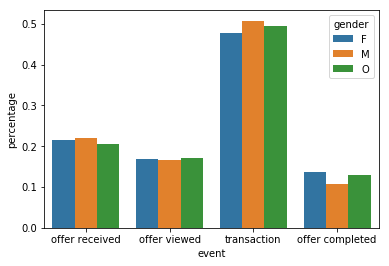

In [34]:
sb.barplot( x= "event", y="percentage", hue="gender", data=gender_pct, order = ['offer received', 'offer viewed', 'transaction', 'offer completed']);

In [35]:
offer_num = transcript.groupby('person').size().reset_index(name = 'offer_num')
profile = profile.merge(offer_num, how = 'left', left_on = 'id', right_on = 'person')

profile.drop('person', axis = 1, inplace = True)

In [36]:
profile.head()

,age,became_member_on,gender,id,income,offer_num
0,54.0,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,65405.0,21
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,6
2,54.0,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,65405.0,10
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,18
4,54.0,2017-08-04,F,a03223e636434f42ac4c3df47e8bac43,65405.0,11


In [37]:
profile[['age', 'income', 'offer_num']].corr()

,age,income,offer_num
age,1.000000,0.306693,-0.078640
income,0.306693,1.000000,-0.124043
offer_num,-0.078640,-0.124043,1.000000


> offer_num has slightly negative correlation with income. The lower income, the more offers.

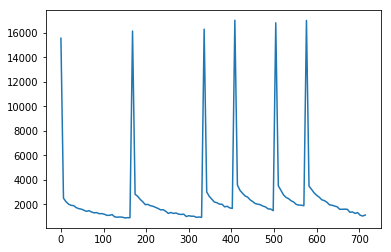

In [38]:
time_df = transcript.groupby('time').size().reset_index(name = 'offer_num')
plt.plot(time_df['time'], time_df['offer_num'])

> Offers are released periodically.

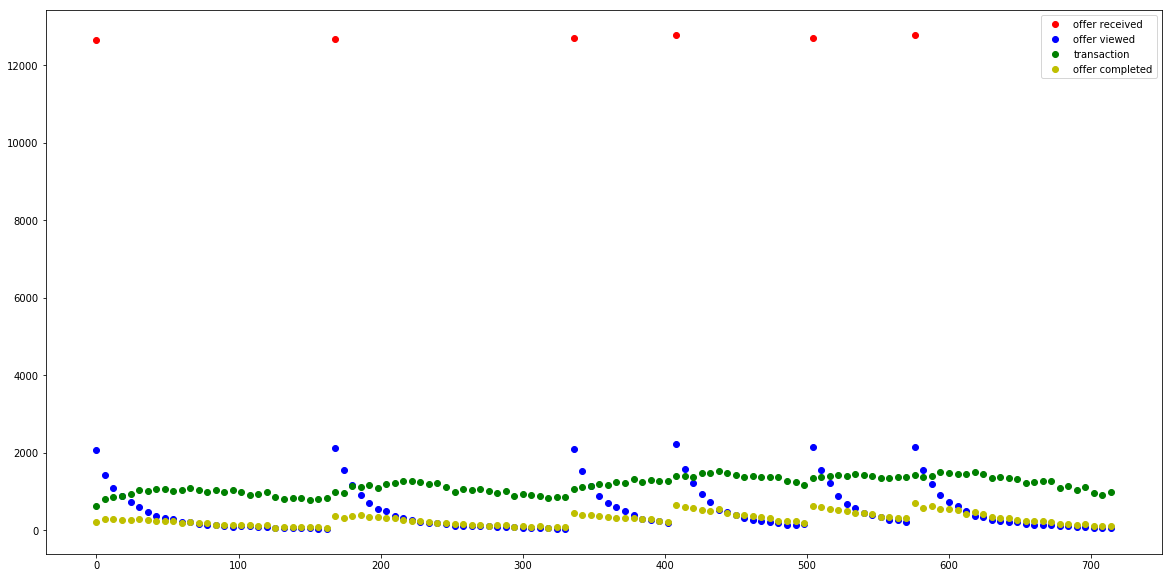

In [39]:
plt.figure(figsize = (20,10))
type_time_df = transcript.groupby(['event','time']).size().reset_index(name = 'offer_num')
plt.plot(type_time_df.query('event == "offer received"')['time'], type_time_df.query('event == "offer received"')['offer_num'], 'ro', label = 'offer received')
plt.plot(type_time_df.query('event == "offer viewed"')['time'], type_time_df.query('event == "offer viewed"')['offer_num'], 'bo', label = 'offer viewed')
plt.plot(type_time_df.query('event == "transaction"')['time'], type_time_df.query('event == "transaction"')['offer_num'], 'go', label = 'transaction')
plt.plot(type_time_df.query('event == "offer completed"')['time'], type_time_df.query('event == "offer completed"')['offer_num'], 'yo', label = 'offer completed')
plt.legend();


In [40]:
def offer_type_pct(x):
    return offer_pct.query('offer_id == @x')['counts'].sum()
offer_pct = not_inf.groupby(['event', 'offer_id']).size().reset_index(name = 'counts')
offer_pct['total'] = offer_pct['offer_id'].apply(lambda x : offer_type_pct(x))
offer_pct['percentage'] = offer_pct['counts']/offer_pct['total']

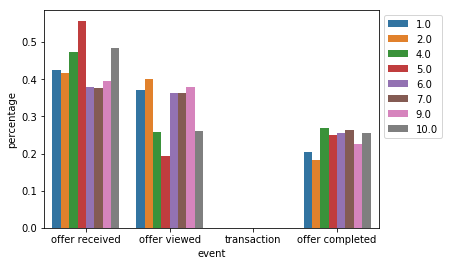

In [41]:
sb.barplot( x= "event", y="percentage", hue="offer_id", data=offer_pct, order = ['offer received', 'offer viewed', 'transaction', 'offer completed'])
plt.legend(loc='best',bbox_to_anchor=(1, 1));

In [42]:
portfolio = portfolio.merge(offer_pct.query('event == "offer completed"')[['offer_id', 'percentage']], how = 'left', left_on = 'simple_id', right_on = 'offer_id')
portfolio.drop('offer_id', axis = 1, inplace = True)
portfolio = portfolio.rename(columns = {'percentage':'completed rate'})

In [43]:
portfolio.iloc[[0,1,3,4,5,6,8,9],:].corr().loc['completed rate'].sort_values()

reward           -0.877836
bogo             -0.615480
social           -0.526682
mobile           -0.142961
difficulty       -0.033187
web               0.440926
simple_id         0.540107
duration          0.592372
discount          0.615480
completed rate    1.000000
email                  NaN
informational          NaN
Name: completed rate, dtype: float64

> - email/ informational is Nan is because all offer_id have same values for these two variables.
> - Discount is positively correlated to completed rate, but bogo is negatively correlated to completed rate. Therefore, Starbucks should use discount as promotion more than bogo.

In [44]:
def respond(x):
    if x == 'transaction' or x == 'offer completed':
        return 1
    else:
        return 0
transcript['responded'] = transcript['event'].apply(lambda x: respond(x)) 

In [45]:
trans_ppl['responded'] = trans_ppl['event'].apply(lambda x: respond(x)) 

In [46]:
xbin_edges = np.arange(15,110,5)
trans_ppl['age_group'] = pd.cut(trans_ppl['age'], bins = xbin_edges, include_lowest = False, right = True)
trans_ppl.head()

,event,person,time,value,offer_id,trans_amt,age,became_member_on,gender,income,responded,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},4.0,NaN,75.0,2017-05-09,F,100000.0,0,"(70, 75]"
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5.0,NaN,54.0,2017-08-04,F,65405.0,0,"(50, 55]"
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},10.0,NaN,68.0,2018-04-26,M,70000.0,0,"(65, 70]"
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},7.0,NaN,54.0,2017-09-25,M,65405.0,0,"(50, 55]"
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2.0,NaN,54.0,2017-10-02,M,65405.0,0,"(50, 55]"


In [47]:
age_pct = trans_ppl.groupby(['age_group', 'responded']).size().reset_index(name = 'counts')

In [48]:
total_age_group = trans_ppl.groupby('age_group').size().reset_index(name = 'total')
age_pct = age_pct.merge(total_age_group, how = 'left', on = 'age_group')
age_pct['percentage'] = age_pct['counts']/age_pct['total']
age_pct.head()

,age_group,responded,counts,total,percentage
0,"(15, 20]",0,2570,6544,0.392726
1,"(15, 20]",1,3974,6544,0.607274
2,"(20, 25]",0,5113,13278,0.385073
3,"(20, 25]",1,8165,13278,0.614927
4,"(25, 30]",0,5330,13759,0.387383


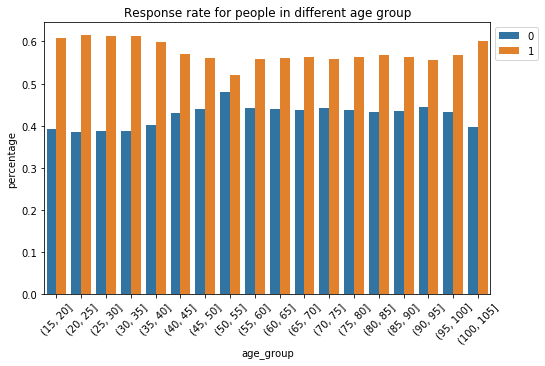

In [49]:
plt.figure(figsize = (8,5))
sb.barplot( x= "age_group", y="percentage", hue="responded", data=age_pct)
plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.title('Response rate for people in different age group');

> Responded rate decline from 35 to 55. However, it increases and stays stable after 55. One possible reason might be that people within age 35-55 are too busy to respond to the offers. For younger and older people, they might have time to respond to the offers. The other possible reason is that people in middle age are not sensitive to discount/promotion. People under 35 have more than 60% to the offers. People over 55 have second response rate and the people aged between 35-55 have the lowest response rate.

In [50]:
trans_ppl = trans_ppl.merge(portfolio, how = 'left', left_on = 'offer_id', right_on = 'simple_id')
trans_ppl.drop(['id','completed rate'], axis = 1, inplace = True)

In [51]:
age_off = trans_ppl.query('offer_id != 3 and offer_id != 8').groupby(['age_group','offer_id','event']).size().reset_index(name = 'counts')
total = trans_ppl.query('offer_id != 3 and offer_id != 8').groupby(['age_group','offer_id']).size().reset_index(name = 'total')
age_off = age_off.merge(total, how = 'left', on = ['age_group','offer_id'])
age_off['percentage'] = age_off['counts']/age_off['total']
age_off.head()

,age_group,offer_id,event,counts,total,percentage
0,"(15, 20]",1.0,offer completed,54,358,0.150838
1,"(15, 20]",1.0,offer received,156,358,0.435754
2,"(15, 20]",1.0,offer viewed,148,358,0.413408
3,"(15, 20]",2.0,offer completed,44,371,0.118598
4,"(15, 20]",2.0,offer received,166,371,0.447439


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


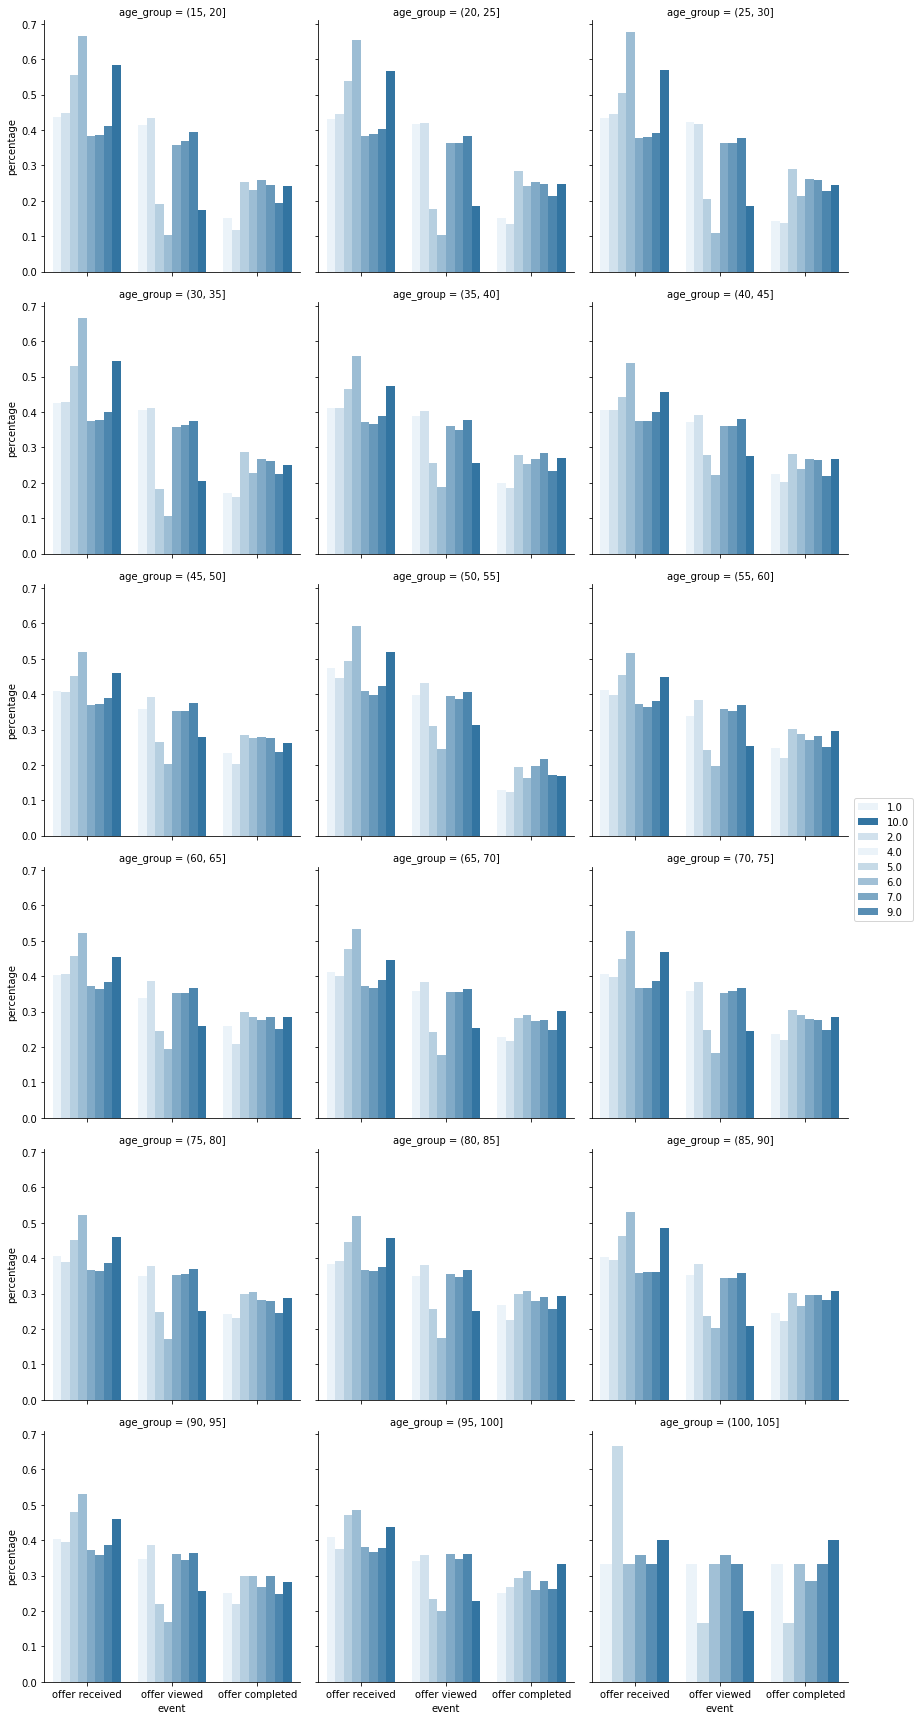

In [52]:
g = sb.FacetGrid(data = age_off, col = 'age_group', col_wrap = 3, legend_out = True, size = 4)
g = (g.map(sb.barplot, "event", "percentage", "offer_id", order = ['offer received', 'offer viewed','offer completed'])).add_legend()


In [53]:
xbin_edges = np.array([15,35,55,105])
trans_ppl['age_class'] = pd.cut(trans_ppl['age'], bins = xbin_edges, include_lowest = False, right = True, labels = ['young','middle','old'])
age_class =trans_ppl.query('offer_id != 3 and offer_id != 8').groupby(['age_class','offer_id','event']).size().reset_index(name = 'counts')
total = trans_ppl.query('offer_id != 3 and offer_id != 8').groupby(['age_class','offer_id']).size().reset_index(name = 'total')
age_class = age_class.merge(total, how = 'left', on = ['age_class','offer_id'])
age_class['percentage'] = age_class['counts']/age_class['total']
age_class.head()

,age_class,offer_id,event,counts,total,percentage
0,young,1.0,offer completed,388,2498,0.155324
1,young,1.0,offer received,1076,2498,0.430745
2,young,1.0,offer viewed,1034,2498,0.413931
3,young,2.0,offer completed,348,2492,0.139647
4,young,2.0,offer received,1100,2492,0.441413


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


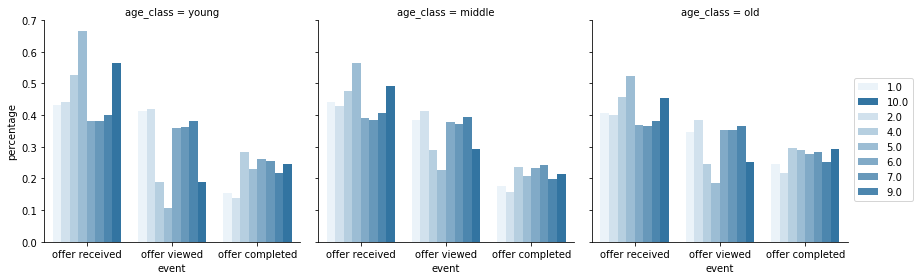

In [54]:
g = sb.FacetGrid(data = age_class, col = 'age_class', col_wrap = 3, legend_out = True, size = 4)
g = (g.map(sb.barplot, "event", "percentage", "offer_id", order = ['offer received', 'offer viewed','offer completed'])).add_legend()


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


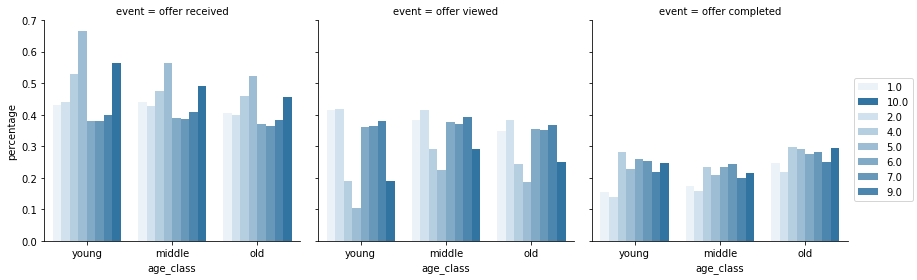

In [55]:
g = sb.FacetGrid(data = age_class, col = 'event', col_wrap = 3, legend_out = True, size = 4, col_order = ['offer received', 'offer viewed', 'offer completed'])
g = (g.map(sb.barplot, "age_class", "percentage", "offer_id")).add_legend()

In [56]:
offer_type = trans_ppl.query('offer_id != 3 and offer_id != 8').groupby(['age_class','offer_type','event']).size().reset_index(name = 'counts')
total = trans_ppl.query('offer_id != 3 and offer_id != 8').groupby(['age_class','offer_type']).size().reset_index(name = 'total')
offer_type = offer_type.merge(total, how = 'left', on = ['age_class','offer_type'])
offer_type['percentage'] = offer_type['counts']/offer_type['total']
offer_type.head()

,age_class,offer_type,event,counts,total,percentage
0,young,bogo,offer completed,1874,9612,0.194965
1,young,bogo,offer received,4281,9612,0.445381
2,young,bogo,offer viewed,3457,9612,0.359655
3,young,discount,offer completed,2322,9288,0.250000
4,young,discount,offer received,4351,9288,0.468454


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


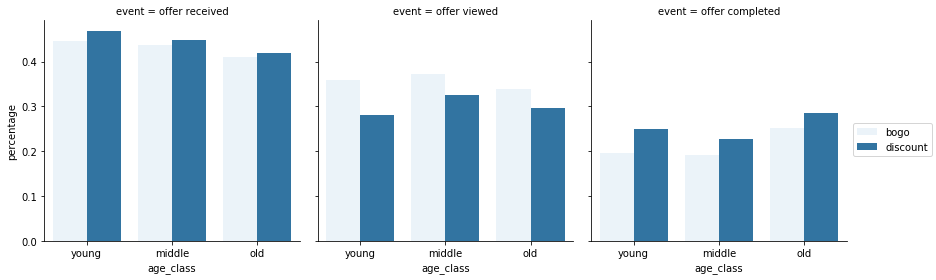

In [57]:
g = sb.FacetGrid(data = offer_type, col = 'event', col_wrap = 3, legend_out = True, size = 4, col_order = ['offer received', 'offer viewed', 'offer completed'])
g = (g.map(sb.barplot, "age_class", "percentage", "offer_type")).add_legend()

> People in middle age have higher offer viewed rate but lower offer completed rate. However, young and old people have lower offer viewed rate but higher offer completed, which means if they reviewed the offers they have higher possibility to complete the offers than people in middle age do. 

> People in all age have higher view rate to bogo offers but, interestingly, lower completed rate to bogo offers. HOwever, we can not get the offer_id for those transaction events. Therefore, we cannot certainly sure if discount offers have higher completed rate unless we can get the offer_id for transaction events. 

In [106]:
response = pd.merge(transcript, profile, how = 'left', left_on = 'person', right_on = 'id')
response = response.query('event != "transaction"')
response.drop(['offer_num', 'id', 'trans_amt', 'value', 'event', 'person'], inplace = True, axis = 1)
response = response.query('offer_id != 3.0 and offer_id != 8.0')

In [107]:
response.shape

(141515, 7)

In [108]:
X = response.iloc[:,[0,1,3,4,5,6]]
Y = response.iloc[:,2]
gender = pd.get_dummies(X.iloc[:,4])
X = pd.concat([X,gender], axis =1)
X.drop('gender', axis = 1, inplace = True)


In [109]:
X['member_days']= X['became_member_on']-datetime.today()
X['member_days'] = X['member_days'].apply(lambda x: abs(x.days))
X.drop('became_member_on', axis = 1, inplace = True)

In [110]:
X.head()

,time,offer_id,age,income,F,M,O,member_days
0,0,4.0,75.0,100000.0,1,0,0,1218
1,0,5.0,54.0,65405.0,1,0,0,1131
2,0,10.0,68.0,70000.0,0,1,0,866
3,0,7.0,54.0,65405.0,0,1,0,1079
4,0,2.0,54.0,65405.0,0,1,0,1072


In [111]:
X = pd.merge(X, portfolio, how = 'left', left_on = 'offer_id', right_on = 'simple_id')
X.drop(['simple_id','id', 'offer_type', 'channels'], axis = 1, inplace = True)

In [112]:
X.head()

,time,offer_id,age,income,F,M,O,member_days,difficulty,duration,reward,email,mobile,web,social,bogo,discount,informational,completed rate
0,0,4.0,75.0,100000.0,1,0,0,1218,5,7,5,1,1,1,0,1,0,0,0.268732
1,0,5.0,54.0,65405.0,1,0,0,1131,20,10,5,1,0,1,0,0,1,0,0.248709
2,0,10.0,68.0,70000.0,0,1,0,866,10,7,2,1,1,1,0,0,1,0,0.254773
3,0,7.0,54.0,65405.0,0,1,0,1079,10,10,2,1,1,1,1,0,1,0,0.262685
4,0,2.0,54.0,65405.0,0,1,0,1072,10,5,10,1,1,1,1,1,0,0,0.182801


In [113]:
from sklearn.preprocessing import StandardScaler
std_scaler =StandardScaler()
X.iloc[:,[0,2,3,7,8,9,10]] = std_scaler.fit_transform(X.iloc[:,[0,2,3,7,8,9,10]])
offer = pd.get_dummies(X.iloc[:,1])
X = pd.concat([X, offer], axis = 1)
X.drop('offer_id', axis = 1, inplace = True)

In [114]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3,random_state = 42)

In [203]:
X_train.shape

(99060, 26)

In [204]:
Y_train = Y_train.reset_index(drop = True)
X_train = X_train.reset_index(drop = True)
idx = list(Y_train[Y_train == 1].index)

In [205]:
positive_X = X_train.iloc[idx,:]
positive_Y = Y_train.iloc[idx]

In [206]:
for i in range(164):
    X_train = pd.concat([X_train, positive_X],axis = 0)
    Y_train = pd.concat([Y_train, positive_Y],axis = 0)                

(333650, 26)

In [115]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
cross_val_score(model, X_train, Y_train, cv=5).mean()

0.7164950389475111

In [116]:
print(recall_score(Y_test, y_pred))
print(accuracy_score(Y_test, y_pred))
confusion_matrix(Y_test, y_pred)

0.161956521739
0.710210811447


array([[28513,  3822],
       [ 8481,  1639]])

> We can use the above random forest model to predict if the member will respond to the offer. The information required are time/offer_id/age/became_member_on/income/gender

In [117]:
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
cross_val_score(model, X_train, Y_train, cv=5).mean()

0.81462746517749962

In [118]:
print(recall_score(Y_test, y_pred))
print(accuracy_score(Y_test, y_pred))
confusion_matrix(Y_test, y_pred)

0.449209486166
0.814250382758


array([[30023,  2312],
       [ 5574,  4546]])

In [96]:
response = pd.merge(transcript, profile, how = 'left', left_on = 'person', right_on = 'id')
response.drop(['offer_num', 'id', 'trans_amt', 'value', 'event', 'person'], inplace = True, axis = 1)
response = response.query('offer_id != 3.0 and offer_id != 8.0')
response.drop('offer_id', axis = 1, inplace=True)

In [97]:
X = response.iloc[:,[0,2,3,4,5]]
Y = response.iloc[:,1]
gender = pd.get_dummies(X.iloc[:,3])
X = pd.concat([X,gender], axis =1)
X.drop('gender', axis = 1, inplace = True)

In [98]:
X['member_days']= X['became_member_on']-datetime.today()
X['member_days'] = X['member_days'].apply(lambda x: abs(x.days))
X.drop('became_member_on', axis = 1, inplace = True)

In [99]:
X.head()

,time,age,income,F,M,O,member_days
0,0,75.0,100000.0,1,0,0,1218
1,0,54.0,65405.0,1,0,0,1131
2,0,68.0,70000.0,0,1,0,866
3,0,54.0,65405.0,0,1,0,1079
4,0,54.0,65405.0,0,1,0,1072


In [100]:
from sklearn.preprocessing import StandardScaler
std_scaler =StandardScaler()
X.iloc[:,[0,1,2,6]] = std_scaler.fit_transform(X.iloc[:,[0,1,2,6]])
X.head()

,time,age,income,F,M,O,member_days
0,-1.840168,1.277773,1.776182,1,0,0,-0.324593
1,-1.840168,0.012237,0.051950,1,0,0,-0.530753
2,-1.840168,0.855928,0.280967,0,1,0,-1.158713
3,-1.840168,0.012237,0.051950,0,1,0,-0.653976
4,-1.840168,0.012237,0.051950,0,1,0,-0.670563


In [101]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3,random_state = 42)

In [102]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
cross_val_score(model, X_train, Y_train, cv=5).mean()

0.75770523098604725

In [103]:
print(recall_score(Y_test, y_pred))
print(accuracy_score(Y_test, y_pred))
confusion_matrix(Y_test, y_pred)

0.825316848184
0.763064380029


array([[21617, 10922],
       [ 9014, 42588]])

In [104]:
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
cross_val_score(model, X_train, Y_train, cv=5).mean()

0.83998124556709475

In [105]:
print(recall_score(Y_test, y_pred))
print(accuracy_score(Y_test, y_pred))
confusion_matrix(Y_test, y_pred)

0.931456145111
0.837736656327


array([[22423, 10116],
       [ 3537, 48065]])